## Problem statement:

- In the following project, we will leverage the power of deep learning in order to detect and classify disease.


- AI/ML/DL have been revolutionizing health care and medicine 


- Deep learning has been proven to be superior in detecting and classifying desease using imagery data

### Importing Libraries 

In [1]:
# importing Operating system library
import os
# OpenCV-Python is a library of Python bindings designed to solve computer vision problems.
import cv2
# Googles framework to simply build and train deep learning models
import tensorflow as tf
import numpy as np
# keres is an api
from tensorflow.keras import layers, optimizers
# Resudial network (massive network a pre-trained network)
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Training data

In [2]:
# training data

X_ray_data = "C:\\Users\\charl\\Desktop\\Study\\DataScience\\Ryan Ahmed\\Data Science for Business Package\\4. Operations Department\\Dataset"

In [3]:
# List the folders in the directory

os.listdir(X_ray_data)

['0', '1', '2', '3']

In [4]:
# Use image generator to generate tensor images data and normalize them

#### Image Generator

Keras ImageDataGenerator is a gem! It lets you augment your images in real-time while your model is still training! You can apply any random transformations on each training image as it is passed to the model. This will not only make your model robust but will also save up on the overhead memory!

In [5]:
# Using 20% of the data for cross validation

In [6]:
# creating an instance of image generator
# rescale ==> scaling the image
# validation ==> train test split
image_generator = ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [7]:
# Generate Batch of 40 images
# Total no of images is 133*4 = 532 images
# Training is 428(80%) and validation is 104 (20%)
# Perform shuffling and image resizing

In [8]:
# train_generator for training data
# batch size you can take anything (Taking first 40 images)
# directory is where the images exists
# Shuffle --> Model should not memorize the order
# target size => the dimensions of the image
# class mode ==> we are predicting categorical values
# Subset ==> naming the subset as training

train_generator = image_generator.flow_from_directory(batch_size=40, directory=X_ray_data, shuffle=True, target_size=(256, 256), class_mode="categorical", subset="training")                                  

Found 428 images belonging to 4 classes.


In [9]:
# cross validation for testing

validation_generator = image_generator.flow_from_directory(batch_size=40, directory=X_ray_data, shuffle=True, target_size=(256, 256), class_mode="categorical", subset="validation")                                  

Found 104 images belonging to 4 classes.


In [10]:
# Generate a batch of 40 images and 40 labels

In [11]:
train_images, train_labels = next(train_generator)

In [12]:
# 40 are the images
# 256*256 dimensions
# 3 (RGB)

train_images.shape

(40, 256, 256, 3)

In [13]:
# 40 are the images

train_labels.shape

(40, 4)

In [14]:
train_labels

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]],

### There are 4 classes

- Healthy
- Covid-19
- Bacterial Pneumonia
- Viral Pneumonia

In [15]:
# label translator
label_names = {0:"Healthy", 1:"Covid-19", 2:"Bacterial Pneumonia", 3:"Viral Pneumonia"}

In [16]:
label_names

{0: 'Healthy', 1: 'Covid-19', 2: 'Bacterial Pneumonia', 3: 'Viral Pneumonia'}

### Image Visualization

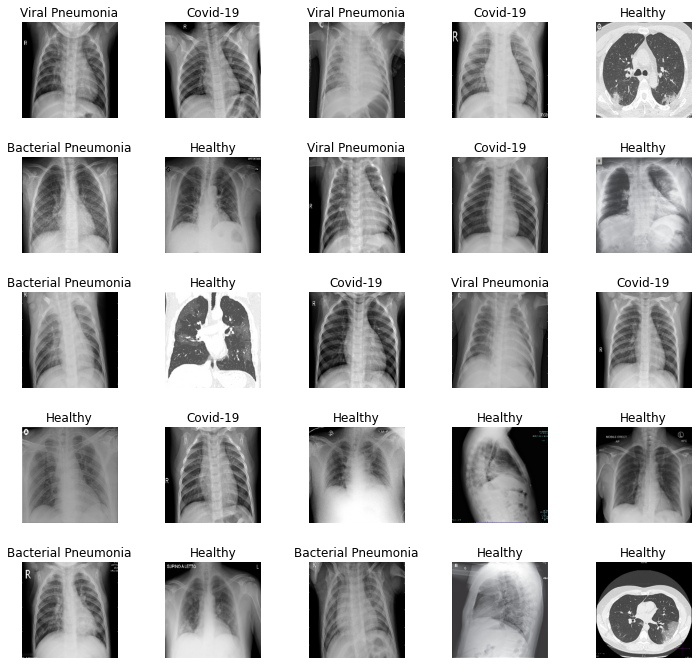

In [17]:
# Defining the Length and Width

L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):
    
    axes[i].imshow(train_images[i])
    
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    
    axes[i].axis("off")
    

plt.subplots_adjust(wspace=0.5)

### Convolutional Neural Networks

#### Import model with pretrained weights

In [18]:
basemodel = ResNet50(weights = "imagenet", include_top= False, input_tensor=Input(shape=(256, 256, 3)))                                    

In [19]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [20]:
# freezing layers in the model

In [21]:
for layer in basemodel.layers[:-10]:
    
    layer.trainable = False

### Build and Train Deep Learning Model

In [30]:
# building a head model
headmodel = basemodel.output
# adding an average pooling layer on top of it
headmodel = AveragePooling2D(pool_size= (4, 4))(headmodel)
# adding a flattining layer
headmodel = Flatten(name = "Flattening")(headmodel)
# adding a neural network
headmodel = Dense(256, activation="relu")(headmodel)
# adding dropout to avoid overfitting
headmodel = Dropout(0.3)(headmodel)
# adding a neural network
# Try and error
headmodel = Dense(128, activation="relu")(headmodel)
# adding dropout to avoid overfitting
headmodel = Dropout(0.2)(headmodel)
# Try and error
headmodel = Dense(64, activation="relu")(headmodel)
# adding dropout to avoid overfitting
headmodel = Dropout(0.1)(headmodel)
# adding dense layer
headmodel = Dense(4,activation="softmax")(headmodel)

In [31]:
model = Model(inputs = basemodel.input, outputs = headmodel)

In [32]:
model.compile(loss="categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-4), metrics=['accuracy'])                           

In [33]:
# using early stopping to exit training if validation loss is not decreasing after certain number of epochs

earlystopping = EarlyStopping(monitor="val_loss", mode="min", patience=20)

In [34]:
# Save the best model with low validation loss

checkPointer = ModelCheckpoint(filepath="lung.hdf5", verbose=1, save_best_only=True)

In [35]:
train_generator = image_generator.flow_from_directory(batch_size=4, directory=X_ray_data, shuffle=True, target_size = (256,256), class_mode="categorical", subset="training")                                                        

validation_generator = image_generator.flow_from_directory(batch_size=4, directory=X_ray_data, shuffle=True, target_size = (256,256), class_mode="categorical", subset="validation")                                                        

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [36]:
history = model.fit_generator(train_generator, epochs=25, validation_data=validation_generator, callbacks=[checkPointer,earlystopping])                          

Epoch 1/25
107/107 [==============================] - ETA: 0s - loss: 1.0292 - accuracy: 0.5841
Epoch 00001: val_loss improved from inf to 1.02023, saving model to lung.hdf5
107/107 [==============================] - 90s 846ms/step - loss: 1.0292 - accuracy: 0.5841 - val_loss: 1.0202 - val_accuracy: 0.5673
Epoch 2/25
107/107 [==============================] - ETA: 0s - loss: 0.7691 - accuracy: 0.6869
Epoch 00002: val_loss improved from 1.02023 to 0.96258, saving model to lung.hdf5
107/107 [==============================] - 87s 813ms/step - loss: 0.7691 - accuracy: 0.6869 - val_loss: 0.9626 - val_accuracy: 0.6635
Epoch 3/25
107/107 [==============================] - ETA: 0s - loss: 0.6769 - accuracy: 0.7407
Epoch 00003: val_loss improved from 0.96258 to 0.70860, saving model to lung.hdf5
107/107 [==============================] - 85s 795ms/step - loss: 0.6769 - accuracy: 0.7407 - val_loss: 0.7086 - val_accuracy: 0.7308
Epoch 4/25
107/107 [==============================] - ETA: 0s - loss

 ###  Evaluate Trained Deep Learning Model

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0, 0.5, 'Training Accuracy and loss')

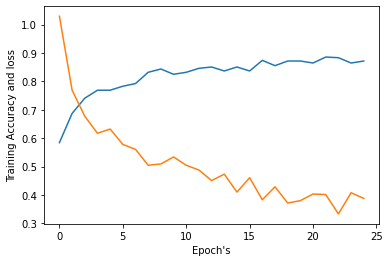

In [40]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.xlabel("Epoch's")
plt.ylabel("Training Accuracy and loss")

Text(0, 0.5, 'Validation Loss')

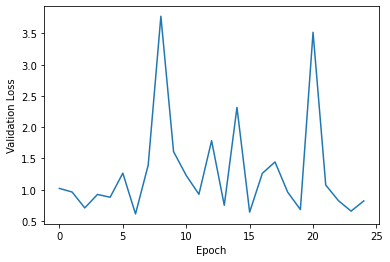

In [41]:
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")

Text(0, 0.5, 'Validation Accuracy')

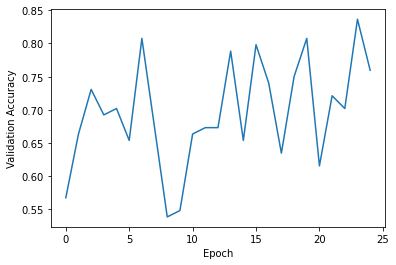

In [42]:
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")

In [44]:
test_directory = "C:\\Users\\charl\\Desktop\\Study\\DataScience\\Ryan Ahmed\\Data Science for Business Package\\4. Operations Department\\Test"

In [45]:
test_gen = ImageDataGenerator(rescale=1./255)

In [46]:
test_generator = test_gen.flow_from_directory(batch_size=40, directory = test_directory, shuffle=True, target_size = (256,256), class_mode="categorical")            

Found 40 images belonging to 4 classes.


In [47]:
evaluate = model.evaluate_generator(test_generator, steps=test_generator.n //4 , verbose=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
 1/10 [==>...........................] - 1s 1s/step - loss: 1.6517 - accuracy: 0.6750


In [48]:
print("Accuracy Test: {}".format(evaluate[1]))

Accuracy Test: 0.675000011920929


In [54]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [50]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
    
    for item in os.listdir(os.path.join(test_directory,str(i))):
        
        img = cv2.imread(os.path.join(test_directory,str(i),item))
        
        img = cv2.resize(img,(256,256))
        
        image.append(img)
        
        img = img/255
        
        img = img.reshape(-1, 256,256, 3)
        
        predict = model.predict(img)
        
        predict = np.argmax(predict)
        
        prediction.append(predict)
        
        original.append(i)

In [51]:
score = accuracy_score(original,prediction)
print("Test Accuracy: {}".format(score))

Test Accuracy: 0.725


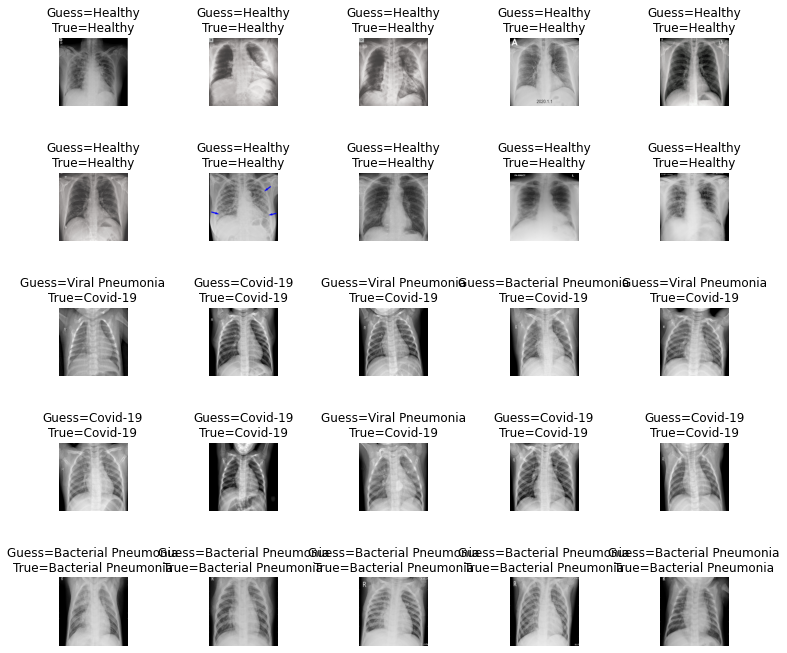

In [52]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [55]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       1.00      0.50      0.67        10
           2       0.86      0.60      0.71        10
           3       0.53      0.80      0.64        10

    accuracy                           0.73        40
   macro avg       0.79      0.73      0.72        40
weighted avg       0.79      0.72      0.72        40



Text(0.5, 1.0, 'Confusion_matrix')

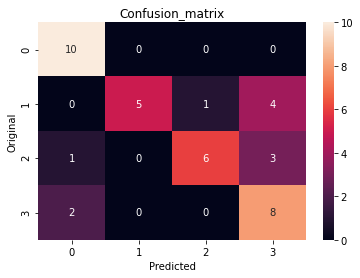

In [56]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')